<a href="https://colab.research.google.com/github/Osterne/codes_DS_course/blob/main/05_mod_ap_n_sup_03_mistura_normais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

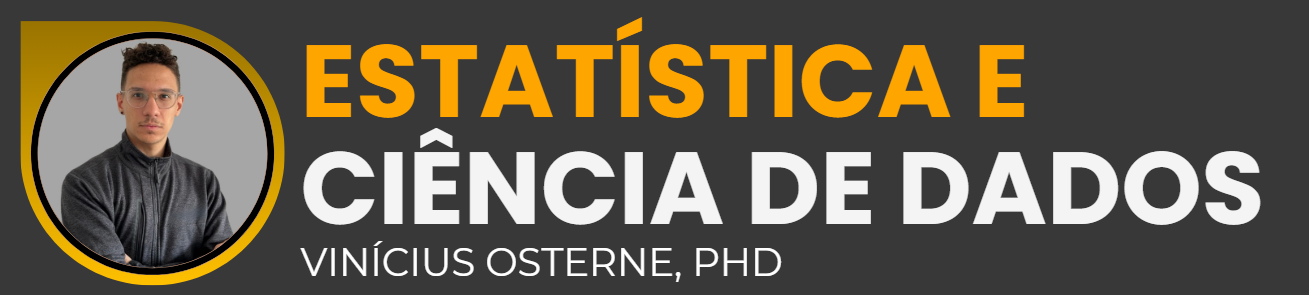

---

# Aprendizado Não Supervisionado - Métodos de Clusterização Probabilística

### Mistura de Normais / Gaussian Mixture Model (GMM)



---
<br><br><br><br><br>

# Introdução

- O **Gaussian Mixture Model (GMM)** é um algoritmo de **aprendizado não supervisionado**, pertencente à categoria de **agrupamento probabilístico**.  
- Seu objetivo é **modelar os dados como uma combinação de distribuições gaussianas (normais)**, em que cada cluster é representado por uma gaussiana com sua própria média e matriz de covariância.  
- Diferente do K-means, que faz uma atribuição **dura** (cada ponto pertence a apenas um cluster), o GMM permite atribuições **probabilísticas** (*soft clustering*), indicando a probabilidade de cada ponto pertencer a cada cluster.  
- Na prática, o GMM é útil para identificar **clusters elípticos ou com formas mais complexas**, que o K-means não consegue capturar.  

### Quando usar
- Quando os clusters não são esféricos (ex.: têm formas alongadas ou variâncias diferentes).  
- Quando se deseja obter **probabilidades de pertencimento** em vez de atribuições rígidas.  
- Em aplicações como:  
  - **Reconhecimento de fala** (modelagem de sons).  
  - **Visão computacional** (segmentação de imagens).  
  - **Modelagem de dados financeiros** (detecção de regimes de mercado).  

### Condições implícitas
- Assume que os clusters seguem distribuições **aproximadamente gaussianas**.  
- Requer que as variáveis estejam na mesma escala (normalização recomendada).  
- Pode ser influenciado por **outliers**, pois eles distorcem a estimação das gaussianas.  
- O número de componentes (clusters) precisa ser escolhido ou validado com critérios estatísticos.  

> ⚠️ **Atenção**: GMM pode sofrer de **overfitting** se o número de componentes for muito alto ou se os dados não tiverem estrutura gaussiana.  

<br><br><br>


# Estrutura do Modelo

### Ideia central
- O GMM assume que os dados são gerados por uma mistura de $K$ distribuições gaussianas.  
- Cada componente tem parâmetros próprios:  
  - **$\mu_k$**: vetor de médias.  
  - **$\Sigma_k$**: matriz de covariância.  
  - **$\pi_k$**: peso do componente (proporção de pontos).  

### Função de verossimilhança
O modelo procura maximizar a verossimilhança dos dados sob a mistura:

$$
p(x) = \sum_{k=1}^K \pi_k \, N(x \mid \mu_k, \Sigma_k)
$$

onde $N(x \mid \mu_k, \Sigma_k)$ é a densidade da normal multivariada.  

<br><br><br>


# Algoritmo EM (Expectation-Maximization)

1. **Inicializar** os parâmetros ($\mu_k$, $\Sigma_k$, $\pi_k$), muitas vezes usando K-means.  
2. **E-step (Expectation)**: calcular a probabilidade de cada ponto pertencer a cada cluster.  
3. **M-step (Maximization)**: atualizar $\mu_k$, $\Sigma_k$ e $\pi_k$ maximizando a verossimilhança com base nas probabilidades calculadas.  
4. **Repetir** E-step e M-step até convergência (quando a variação da log-verossimilhança se torna mínima).  

> 🔄 O algoritmo sempre converge, mas pode parar em **máximos locais**, por isso costuma-se rodar várias inicializações.  

<br><br><br>


# Escolha do número de clusters

- O número de componentes ($K$) pode ser escolhido usando critérios de informação:  
  - **AIC (Akaike Information Criterion)**  
  - **BIC (Bayesian Information Criterion)**  
  - Ambos penalizam modelos mais complexos, evitando overfitting.  

- Também é possível avaliar a qualidade dos clusters com métricas como **Silhouette Score** ou análise visual.  

> 📌 Em aplicações práticas, a escolha de $K$ deve equilibrar **ajuste estatístico (AIC/BIC)** e **interpretação dos clusters**.  

<br><br><br>


# Aplicação
- Vamos ilustrar o **Gaussian Mixture Model (GMM)** utilizando uma aplicação em **dados reais** (Palmer Penguins).  
- Usaremos variáveis numéricas (comprimento do bico, profundidade do bico, comprimento da nadadeira e massa corporal).  
- Compararemos os resultados com o K-means para mostrar como o GMM captura clusters mais flexíveis.

> Objetivo: identificar grupos de vinhos com base em características químicas sem usar a informação das cultivares reais.


In [11]:
# ## 1) Setup
# - Importar bibliotecas
# - Carregar dataset real (Wine)

# %%
!pip -q install scikit-learn matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [12]:
# ## 2) Carregar e explorar os dados
# O dataset Wine possui:
# - 178 vinhos de 3 cultivares diferentes
# - 13 variáveis químicas (álcool, acidez, magnésio, fenóis, etc.)

# %%
wine = load_wine()
X_raw = pd.DataFrame(wine.data, columns=wine.feature_names)
y_true = wine.target  # rótulos reais (não usados no GMM)

print(X_raw.shape)
X_raw.head()


(178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [13]:
# ## 3) Padronização
# É fundamental padronizar para que todas as variáveis tenham mesma escala.

# %%
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)


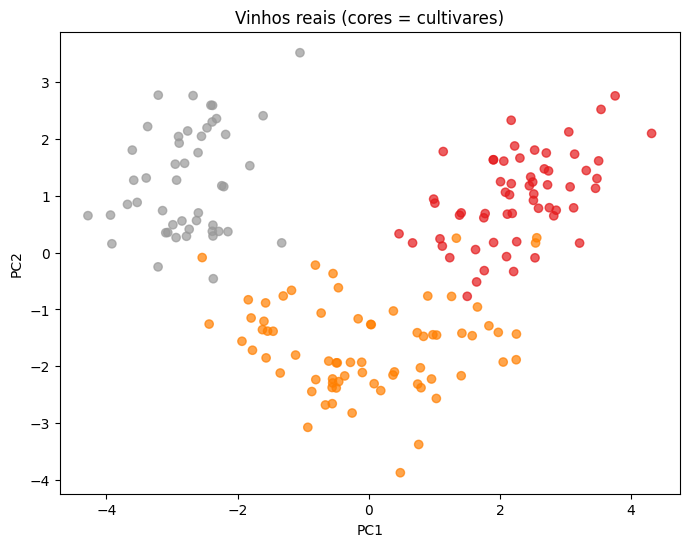

In [14]:
# ## 4) Redução de Dimensão (PCA para visualização): usando os rótulos reais
# Vamos reduzir para 2 componentes principais apenas para plotar.

# %%
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_true, cmap="Set1", alpha=0.7)
plt.title("Vinhos reais (cores = cultivares)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


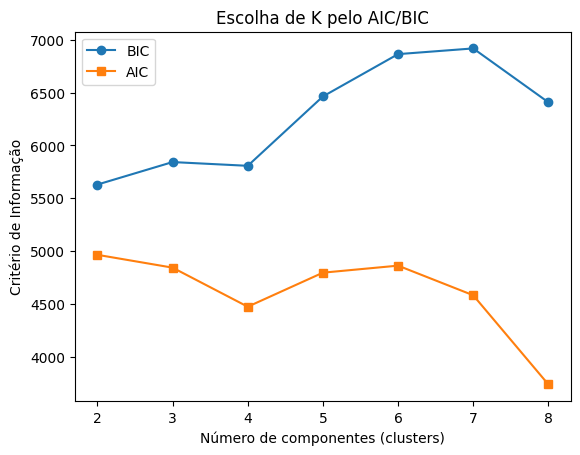

Melhor número de componentes (via BIC): 2


In [15]:
# ## 5) Ajustar o modelo GMM
# Testaremos 2 a 8 componentes (clusters) e escolheremos o melhor via BIC.

# %%
n_components = np.arange(2, 9)
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X)
          for n in n_components]

bics = [m.bic(X) for m in models]
aics = [m.aic(X) for m in models]

plt.plot(n_components, bics, marker='o', label="BIC")
plt.plot(n_components, aics, marker='s', label="AIC")
plt.xlabel("Número de componentes (clusters)")
plt.ylabel("Critério de Informação")
plt.title("Escolha de K pelo AIC/BIC")
plt.legend()
plt.show()

best_n = n_components[np.argmin(bics)]
print(f"Melhor número de componentes (via BIC): {best_n}")


In [16]:
# ## 6) Treinar GMM com o número de clusters escolhido
# Também salvamos as probabilidades de pertencimento (soft clustering).

# %%
gmm = GaussianMixture(n_components=best_n, covariance_type='full', random_state=42)
labels_gmm = gmm.fit_predict(X)
probs = gmm.predict_proba(X)  # probabilidades de cada cluster

print("Exemplo de probabilidades (primeiras linhas):")
print(pd.DataFrame(probs).head())


Exemplo de probabilidades (primeiras linhas):
     0             1
0  1.0  2.639315e-43
1  1.0  4.787913e-36
2  1.0  6.055181e-46
3  1.0  2.013129e-67
4  1.0  1.245628e-17


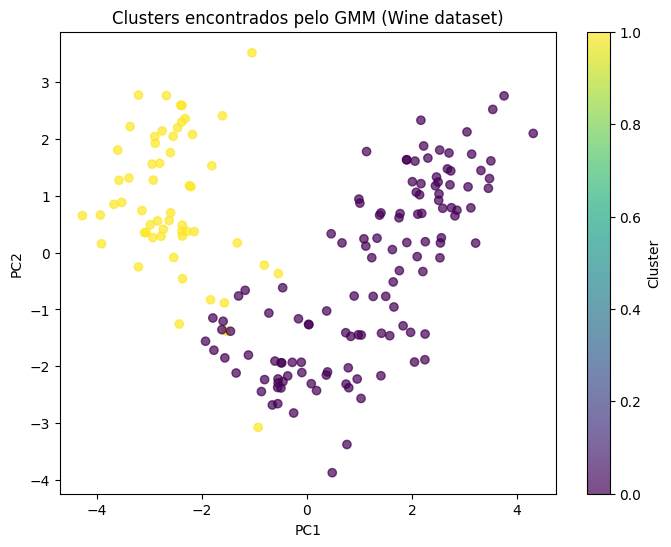

In [17]:
# ## 7) Visualização em 2D (PCA) dos clusters GMM

# %%
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_gmm, cmap="viridis", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters encontrados pelo GMM (Wine dataset)")
plt.colorbar(label="Cluster")
plt.show()


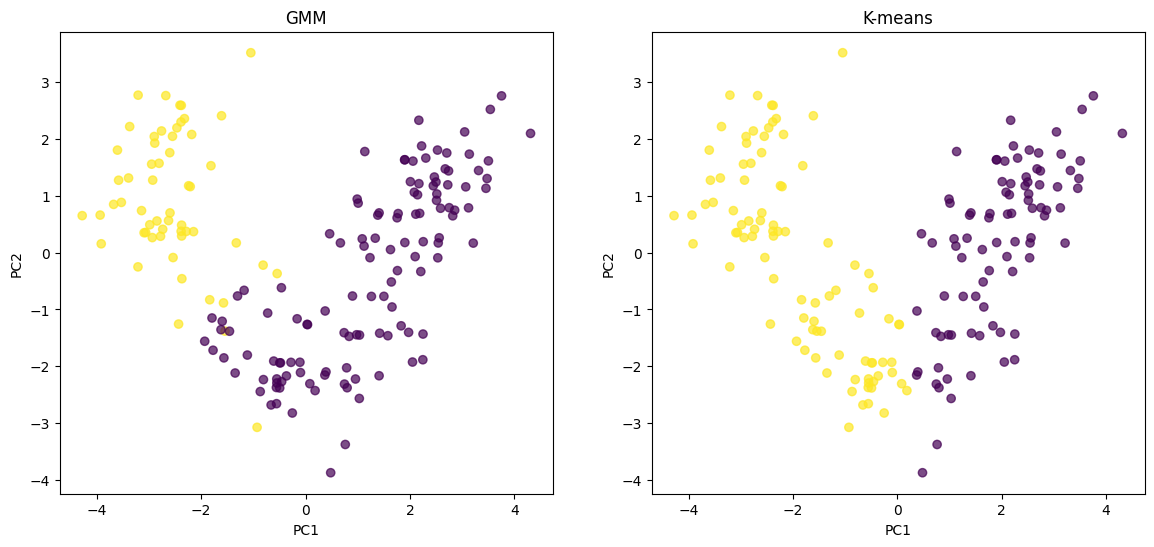

In [18]:
# ## 8) Comparação com K-means
# Vamos rodar K-means com o mesmo número de clusters e comparar resultados.

# %%
kmeans = KMeans(n_clusters=best_n, n_init=30, random_state=42)
labels_km = kmeans.fit_predict(X)

fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].scatter(X_pca[:,0], X_pca[:,1], c=labels_gmm, cmap="viridis", alpha=0.7)
axs[0].set_title("GMM")

axs[1].scatter(X_pca[:,0], X_pca[:,1], c=labels_km, cmap="viridis", alpha=0.7)
axs[1].set_title("K-means")

for ax in axs:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.show()


In [19]:
# ## 9) Avaliação
# Podemos avaliar com Silhouette Score.

# %%
print(f"Silhouette (GMM, k={best_n}): {silhouette_score(X, labels_gmm):.3f}")
print(f"Silhouette (K-means, k={best_n}): {silhouette_score(X, labels_km):.3f}")


Silhouette (GMM, k=2): 0.268
Silhouette (K-means, k=2): 0.259


In [20]:
#Ambos os métodos encontraram clusters fracos/moderados (valores perto de 0, longe de 1).
#O GMM teve uma separação ligeiramente melhor que o K-means (0.268 vs 0.259), mas a diferença é pequena.
#Com K=2, os grupos não estão super bem definidos — talvez seja interessante testar K=3 (até porque o dataset Wine tem 3 classes reais).